# Spatial distribution of freshwater change

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import statsmodels.api as sm

import shapely
import geopandas as gpd
import salem

import cartopy
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]

In [4]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https:

### Load datasets

In [5]:
# ECCOv4r4
ec = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_interp_salt.nc')

In [6]:
# HadOBS EN4
en = xr.open_dataset('/mnt/efs/data/hadobs/salinity.nc')

# Add area
nc = xr.open_dataset('/mnt/efs/data/hadobs/hadobs_en4_area.nc')
en['area'] = nc.area
en.area.attrs= {'units': 'm^2','long_name': 'Grid area'}

### Set spatial and temporal range

In [10]:
south,north,west,east = 40,90,-110,45

tstart = '1992-01-01'
tend = '2017-12-31'

### Get salinity fields

In [11]:
# ECCO
psal_ec = ec.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

# EN4
psal_en = en.salinity.sel(time=slice(tstart,tend),lat=slice(south,north),lon=slice(west,east))

### Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [12]:
psal_ref = 35.0

#### ECCO

In [13]:
f_ec = (psal_ref - psal_ec)/psal_ref
h_fw_ec = (f_ec * ec.dz).sum('depth')

#### EN4

In [14]:
f_en = (psal_ref - psal_en)/psal_ref

depth_bnds = en.depth_bnds
dz = (depth_bnds[:,1]-depth_bnds[:,0])
h_fw_en = (f_en * dz).sum('depth')

## Annual mean freshwater content

In [15]:
h_fw_ec_annual = h_fw_ec.groupby('time.year').mean('time') - h_fw_ec.mean('time')
h_fw_en_annual = h_fw_en.groupby('time.year').mean('time') - h_fw_en.mean('time')

In [16]:
#lfwc_spna_ec_monthly = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_lfwc_spna_monthly.nc').lfwc
#lfwc_spna_en_monthly = xr.open_dataset('/mnt/efs/data/hadobs/en4_lfwc_spna_monthly.nc').lfwc
#Vfw_spna_ec = lfwc_spna_ec_monthly.groupby('time.year').mean('time')
#Vfw_spna_en = lfwc_spna_en_monthly.groupby('time.year').mean('time').sel(year=slice(1992,2017))

# Annual mean freshwater content (km^3)
Vfw_spna_ec = (h_fw_ec_annual.salem.roi(shape=gdf_spna.loc[[0]]) * ec.area).sum(dim=['lat','lon'])*1e-9
Vfw_spna_en = (h_fw_en_annual.salem.roi(shape=gdf_spna.loc[[0]]) * en.area).sum(dim=['lat','lon'])*1e-9

In [17]:
def print_OLS_info(arr):
    model = sm.OLS(arr.values, sm.add_constant(arr.year.values))
    results = model.fit()
    
    if results.params[1]>0:
        err = np.abs(results.conf_int()[1][0]-results.params[1])
    elif results.params[1]<0:
        err = np.abs(results.params[1]-results.conf_int()[1][1])
    
    print('Slope:',results.params[1])
    print('Intercept:',results.params[0])
    print('95% conf. int.:', results.conf_int()[1])
    print('Standard error:', results.bse[1])
    print('Err (+/-):', err)
    print('Slope/Err:', results.params[1]/err)
    print('p value:', results.pvalues[1])

In [15]:
print('\n','---- SPNA FW trend / ECCOv4r4 (1998-2005) ----')
print_OLS_info(Vfw_spna_ec.sel(year=slice(1998,2005)))

print('\n','---- SPNA FW trend / EN4 (1998-2005) ----')
print_OLS_info(Vfw_spna_en.sel(year=slice(1998,2005)))

print('\n','---- SPNA FW trend /ECCOv4r4 (2010-2017) ----')
print_OLS_info(Vfw_spna_ec.sel(year=slice(2010,2017)))

print('\n','---- SPNA FW trend / EN4 (2010-2017) ----')
print_OLS_info(Vfw_spna_en.sel(year=slice(2010,2017)))


 ---- SPNA FW trend / ECCOv4r4 (1998-2005) ----
Slope: -1112.2180693452233
Intercept: 2225922.2053671684
95% conf. int.: [-1338.67258005  -885.76355864]
Standard error: 92.54706532225866
Err (+/-): 226.4545107079324
Slope/Err: -4.911441445207935
p value: 2.0133245048183166e-05

 ---- SPNA FW trend / EN4 (1998-2005) ----
Slope: -1182.72907271242
Intercept: 2366846.1028768457
95% conf. int.: [-1792.44805235  -573.01009307]
Standard error: 249.17897223870284
Err (+/-): 609.7189796406152
Slope/Err: -1.9397937610693248
p value: 0.0031701114331894767

 ---- SPNA FW trend /ECCOv4r4 (2010-2017) ----
Slope: 771.9906394418072
Intercept: -1557199.3597982568
95% conf. int.: [ 505.15575771 1038.82552118]
Standard error: 109.04965042570893
Err (+/-): 266.83488173325793
Slope/Err: 2.8931398864618054
p value: 0.0003983625650803958

 ---- SPNA FW trend / EN4 (2010-2017) ----
Slope: 1136.473567359814
Intercept: -2288994.2126709325
95% conf. int.: [ 722.93238704 1550.01474768]
Standard error: 169.005344

In [18]:
def get_OLS_fit(arr):
    model = sm.OLS(arr.values, sm.add_constant(arr.year.values))
    results = model.fit()
    
    if results.params[1]>0:
        err = np.abs(results.conf_int()[1][0]-results.params[1])
    elif results.params[1]<0:
        err = np.abs(results.params[1]-results.conf_int()[1][1])
    return results.params[1],results.params[0],err

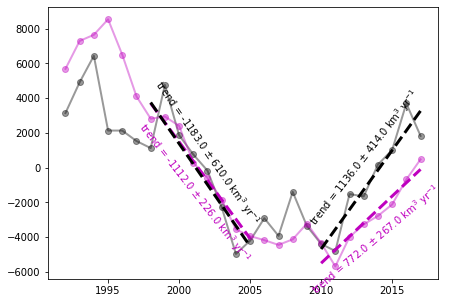

In [17]:
plt.figure(figsize=(7,5))

plt.plot(Vfw_spna_en.year,Vfw_spna_en,color='k',lw=2,ls='-',marker='o',alpha=0.4)
plt.plot(Vfw_spna_ec.year,Vfw_spna_ec,color='m',lw=2,ls='-',marker='o',alpha=0.4)

plt.plot(Vfw_spna_ec.sel(year=slice(1998,2005)).year, 
         get_OLS_fit(Vfw_spna_ec.sel(year=slice(1998,2005)))[0]*Vfw_spna_ec.sel(year=slice(1998,2005)).year+\
         get_OLS_fit(Vfw_spna_ec.sel(year=slice(1998,2005)))[1], c='m', lw=3,linestyle='--')

plt.plot(Vfw_spna_ec.sel(year=slice(2010,2017)).year, 
         get_OLS_fit(Vfw_spna_ec.sel(year=slice(2010,2017)))[0]*Vfw_spna_ec.sel(year=slice(2010,2017)).year+\
         get_OLS_fit(Vfw_spna_ec.sel(year=slice(2010,2017)))[1], c='m', lw=3,linestyle='--')

plt.plot(Vfw_spna_en.sel(year=slice(1998,2005)).year, 
         get_OLS_fit(Vfw_spna_en.sel(year=slice(1998,2005)))[0]*Vfw_spna_en.sel(year=slice(1998,2005)).year+\
         get_OLS_fit(Vfw_spna_en.sel(year=slice(1998,2005)))[1], c='k', lw=3,linestyle='--')
plt.plot(Vfw_spna_en.sel(year=slice(2010,2017)).year, 
         get_OLS_fit(Vfw_spna_en.sel(year=slice(2010,2017)))[0]*Vfw_spna_en.sel(year=slice(2010,2017)).year+\
         get_OLS_fit(Vfw_spna_en.sel(year=slice(2010,2017)))[1], c='k', lw=3,linestyle='--')


plt.text(Vfw_spna_ec.sel(year=slice(1998,2005)).year.median(),Vfw_spna_ec.sel(year=slice(1998,2005)).mean()-1000, 
         r'trend = %s $\pm$ %s km$^3$ yr$^{-1}$'%(str(round(get_OLS_fit(Vfw_spna_ec.sel(year=slice(1998,2005)))[0])),
                                                  str(round(get_OLS_fit(Vfw_spna_ec.sel(year=slice(1998,2005)))[2]))),
         ha='center', va='top', rotation=-52, rotation_mode='anchor', fontsize=10, color ='m')

plt.text(Vfw_spna_en.sel(year=slice(1998,2005)).year.median(),Vfw_spna_en.sel(year=slice(1998,2005)).mean()+1000, 
         r'trend = %s $\pm$ %s km$^3$ yr$^{-1}$'%(str(round(get_OLS_fit(Vfw_spna_en.sel(year=slice(1998,2005)))[0])),
                                                  str(round(get_OLS_fit(Vfw_spna_en.sel(year=slice(1998,2005)))[2]))),
         ha='center', va='bottom', rotation=-55, rotation_mode='anchor', fontsize=10, color ='k')

plt.text(Vfw_spna_ec.sel(year=slice(2010,2017)).year.median(),Vfw_spna_ec.sel(year=slice(2010,2017)).mean()-1000, 
         r'trend = %s $\pm$ %s km$^3$ yr$^{-1}$'%(str(round(get_OLS_fit(Vfw_spna_ec.sel(year=slice(2010,2017)))[0])),
                                                  str(round(get_OLS_fit(Vfw_spna_ec.sel(year=slice(2010,2017)))[2]))),
         ha='center', va='top', rotation=40, rotation_mode='anchor', fontsize=10, color ='m')

plt.text(Vfw_spna_en.sel(year=slice(2010,2017)).year.median(),Vfw_spna_en.sel(year=slice(2010,2017)).mean()+1000, 
         r'trend = %s $\pm$ %s km$^3$ yr$^{-1}$'%(str(round(get_OLS_fit(Vfw_spna_en.sel(year=slice(2010,2017)))[0])),
                                                  str(round(get_OLS_fit(Vfw_spna_en.sel(year=slice(2010,2017)))[2]))),
         ha='center', va='bottom', rotation=52, rotation_mode='anchor', fontsize=10, color ='k')

plt.show()

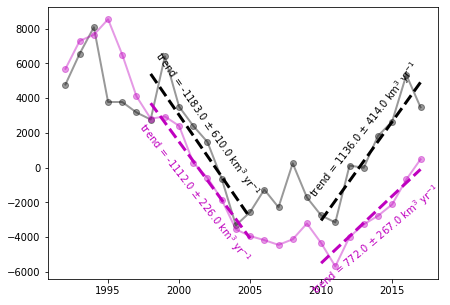

**Monthly**

- ECCOv4r4 (1998-2005): trend = -1108 $\pm$ 54
- EN4 (1998-2005): trend = -1192 $\pm$ 209
- ECCOv4r4 (2010-2017): trend = 771 $\pm$ 62
- EN4 (2010-2017): trend = 1138 $\pm$ 124

### Spatial trends for 1998-2005 and 2010-2017

In [19]:
def get_trend(data):
    return np.polyfit(t, data, 1)[0]

In [20]:
def get_ratio(data):
    try:
        model = sm.OLS(data,sm.add_constant(t))
        results = model.fit()
        if results.params[1]>0:
            err = np.abs(results.conf_int()[1][0]-results.params[1])
        elif results.params[1]<0:
            err = np.abs(results.params[1]-results.conf_int()[1][1])
        elif results.params[1]==0:
            err = results.bse[1]
        else:
            err = np.nan
    
        return results.params[1]/err
    
    except ValueError:
        return np.nan
    
    except RuntimeError:
        return np.nan

In [21]:
t = h_fw_ec_annual.sel(year=slice(1998,2005)).year.astype(int)
h_fw_ec_trend9805 = xr.DataArray(np.apply_along_axis(get_trend, 2, 
                                            h_fw_ec_annual.sel(year=slice(1998,2005)).transpose('lat','lon','year')),
                                 coords=[h_fw_ec_annual.lat,h_fw_ec_annual.lon],dims=['lat','lon'])
h_fw_ec_ratio9805 = xr.DataArray(np.apply_along_axis(get_ratio, 2, 
                                            h_fw_ec_annual.sel(year=slice(1998,2005)).transpose('lat','lon','year')),
                                 coords=[h_fw_ec_annual.lat,h_fw_ec_annual.lon],dims=['lat','lon'])

t = h_fw_ec_annual.sel(year=slice(2010,2017)).year.astype(int)
h_fw_ec_trend1017 = xr.DataArray(np.apply_along_axis(get_trend, 2, 
                                            h_fw_ec_annual.sel(year=slice(2010,2017)).transpose('lat','lon','year')),
                                 coords=[h_fw_ec_annual.lat,h_fw_ec_annual.lon],dims=['lat','lon'])
h_fw_ec_ratio1017 = xr.DataArray(np.apply_along_axis(get_ratio, 2, 
                                            h_fw_ec_annual.sel(year=slice(2010,2017)).transpose('lat','lon','year')),
                                 coords=[h_fw_ec_annual.lat,h_fw_ec_annual.lon],dims=['lat','lon'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [22]:
t = h_fw_en_annual.sel(year=slice(1998,2005)).year.astype(int)
h_fw_en_trend9805 = xr.DataArray(np.apply_along_axis(get_trend, 2, 
                                            h_fw_en_annual.sel(year=slice(1998,2005)).transpose('lat','lon','year')),
                                 coords=[h_fw_en_annual.lat,h_fw_en_annual.lon],dims=['lat','lon'])
h_fw_en_ratio9805 = xr.DataArray(np.apply_along_axis(get_ratio, 2, 
                                            h_fw_en_annual.sel(year=slice(1998,2005)).transpose('lat','lon','year')),
                                 coords=[h_fw_en_annual.lat,h_fw_en_annual.lon],dims=['lat','lon'])

t = h_fw_en_annual.sel(year=slice(2010,2017)).year.astype(int)
h_fw_en_trend1017 = xr.DataArray(np.apply_along_axis(get_trend, 2, 
                                            h_fw_en_annual.sel(year=slice(2010,2017)).transpose('lat','lon','year')),
                                 coords=[h_fw_en_annual.lat,h_fw_en_annual.lon],dims=['lat','lon'])
h_fw_en_ratio1017 = xr.DataArray(np.apply_along_axis(get_ratio, 2, 
                                            h_fw_en_annual.sel(year=slice(2010,2017)).transpose('lat','lon','year')),
                                 coords=[h_fw_en_annual.lat,h_fw_en_annual.lon],dims=['lat','lon'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


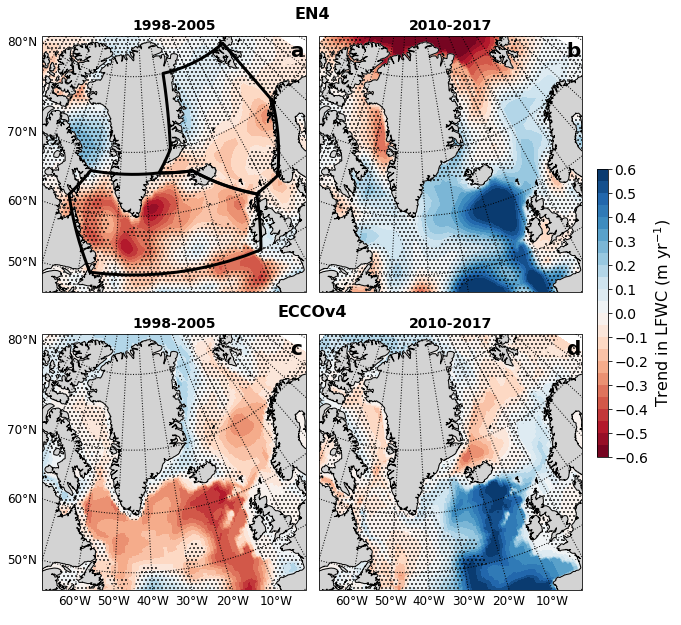

In [33]:
fig, row_axes = plt.subplots(figsize=(10,10), nrows=2, ncols=1, sharey=True)
fig.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, hspace=0.07, wspace = 0.05)

row_axes[0].set_title('EN4', fontsize=16, fontweight='bold')

# Turn off axis lines and ticks of the big subplot / obs alpha is 0 in RGBA string!
row_axes[0].tick_params(axis='both',labelcolor=(1.,1.,1., 0.0), color=(1.,1.,1., 0.0),
                        top='off', bottom='off', left='off', right='off')
# removes the white frame
row_axes[0]._frameon = False

ax11 = fig.add_subplot(2,2,1,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax11.text(0.94,0.92, 'a', fontsize=20, fontweight='bold', transform=ax11.transAxes)
ax11.set_title(r'1998-2005', fontsize=14, fontweight='bold')
ax11.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax11.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax11.coastlines(resolution='50m',linewidth=1.0,zorder=2)

gl = ax11.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
gl_labels = ax11.gridlines(cartopy.crs.PlateCarree(), draw_labels=True, alpha=0.0)
gl_labels.xlocator = mticker.FixedLocator([-70, -60, -50, -40, -30, -20])
gl_labels.ylocator = mticker.FixedLocator([50, 60, 70, 80])
gl_labels.rotate_labels = False
gl_labels.top_labels = False
gl_labels.right_labels = False
gl_labels.bottom_labels = False
gl_labels.xlabel_style= {'size': 12, 'color': 'k'}
gl_labels.ylabel_style= {'size': 12, 'color': 'k'}

p = ax11.contourf(h_fw_en_trend9805.lon-0.5,h_fw_en_trend9805.lat-0.5,np.clip(h_fw_en_trend9805,-0.6,0.6),cmap='RdBu',
                  vmin=-0.6,vmax=0.6,levels = np.arange(-0.6,0.65,0.05),transform=cartopy.crs.PlateCarree())
ax11.contourf(h_fw_en_ratio9805.lon-0.5, h_fw_en_ratio9805.lat-0.5,
              np.ma.masked_invalid(np.clip(h_fw_en_ratio9805,-2,2)),
              levels=3, colors='none', hatches=['','...','...',''], transform=cartopy.crs.PlateCarree())

ax11.add_geometries([gdf_nsea['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                    linewidth=3, linestyle='-')
ax11.add_geometries([gdf_spna['geometry'][0]], cartopy.crs.PlateCarree(), facecolor='none', edgecolor=(0,0,0,1), 
                    linewidth=3, linestyle='-')

ax12 = fig.add_subplot(2,2,2,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax12.text(0.94,0.92, 'b', fontsize=20, fontweight='bold', transform=ax12.transAxes)
ax12.set_title(r'2010-2017', fontsize=14, fontweight='bold')
ax12.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax12.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax12.coastlines(resolution='50m',linewidth=1.0,zorder=2)

gl = ax12.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax12.contourf(h_fw_en_trend1017.lon-0.5,h_fw_en_trend1017.lat-0.5,np.clip(h_fw_en_trend1017,-0.6,0.6),cmap='RdBu',
                  vmin=-0.6,vmax=0.6,levels = np.arange(-0.6,0.65,0.05),transform=cartopy.crs.PlateCarree())
ax12.contourf(h_fw_en_ratio1017.lon-0.5, h_fw_en_ratio1017.lat-0.5,
              np.ma.masked_invalid(np.clip(h_fw_en_ratio1017,-2,2)),
              levels=3, colors='none', hatches=['','...','...',''], transform=cartopy.crs.PlateCarree())

row_axes[1].set_title('ECCOv4', fontsize=16, fontweight='bold')
row_axes[1].tick_params(labelcolor=(1.,1.,1., 0.0), color=(1.,1.,1., 0.0),
                        top='off', bottom='off', left='off', right='off')
row_axes[1]._frameon = False

ax21 = fig.add_subplot(2,2,3,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax21.text(0.94,0.92, 'c', fontsize=20, fontweight='bold', transform=ax21.transAxes)
ax21.set_title(r'1998-2005', fontsize=14, fontweight='bold')
ax21.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax21.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax21.coastlines(resolution='50m',linewidth=1.0,zorder=2)

gl = ax21.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
gl_labels = ax21.gridlines(cartopy.crs.PlateCarree(), draw_labels=True, alpha=0.0, auto_inline=False)
gl_labels.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl_labels.ylocator = mticker.FixedLocator([50, 60, 70, 80])
gl_labels.rotate_labels = False
gl_labels.top_labels = False
gl_labels.right_labels = False
gl_labels.xlabel_style= {'size': 12, 'color': 'k'}
gl_labels.ylabel_style= {'size': 12, 'color': 'k'}
p = ax21.contourf(h_fw_ec_trend9805.lon-0.25,h_fw_ec_trend9805.lat-0.25,np.clip(h_fw_ec_trend9805,-0.6,0.6),
                  cmap='RdBu',vmin=-0.6,vmax=0.6,levels=np.arange(-0.6,0.65,0.05),transform=cartopy.crs.PlateCarree())
ax21.contourf(h_fw_ec_ratio9805.lon-0.25, h_fw_ec_ratio9805.lat-0.25,
              np.ma.masked_invalid(np.clip(h_fw_ec_ratio9805,-2,2)),
              levels=3, colors='none', hatches=['','...','...',''], transform=cartopy.crs.PlateCarree())

ax22 = fig.add_subplot(2,2,4,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax22.text(0.94,0.92, 'd', fontsize=20, fontweight='bold', transform=ax22.transAxes)
ax22.set_title(r'2010-2017', fontsize=14, fontweight='bold')
ax22.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax22.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax22.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax22.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
gl_labels = ax22.gridlines(cartopy.crs.PlateCarree(), draw_labels=True, alpha=0.0, auto_inline=False)
gl_labels.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl_labels.ylocator = mticker.FixedLocator([50, 60, 70, 80])
gl_labels.rotate_labels = False
gl_labels.top_labels = False
gl_labels.right_labels = False
gl_labels.left_labels = False
gl_labels.xlabel_style= {'size': 12, 'color': 'k'}
gl_labels.ylabel_style= {'size': 12, 'color': 'k'}
p = ax22.contourf(h_fw_ec_trend1017.lon-0.25,h_fw_ec_trend1017.lat-0.25,np.clip(h_fw_ec_trend1017,-0.6,0.6),
                  cmap='RdBu',vmin=-0.6,vmax=0.6,levels=np.arange(-0.6,0.65,0.05),transform=cartopy.crs.PlateCarree())
ax22.contourf(h_fw_ec_ratio1017.lon-0.25, h_fw_ec_ratio1017.lat-0.25,
              np.ma.masked_invalid(np.clip(h_fw_ec_ratio1017,-2,2)),
              levels=3, colors='none', hatches=['','...','...',''], transform=cartopy.crs.PlateCarree())

cax = fig.add_axes([0.87, 0.30, 0.015, 0.4])
cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.9, ticks=np.arange(-0.6,0.7,0.1))
cb.set_label(r'Trend in LFWC (m yr$^{-1}$)',fontsize=16)
cb.ax.tick_params(labelsize=14)

#plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


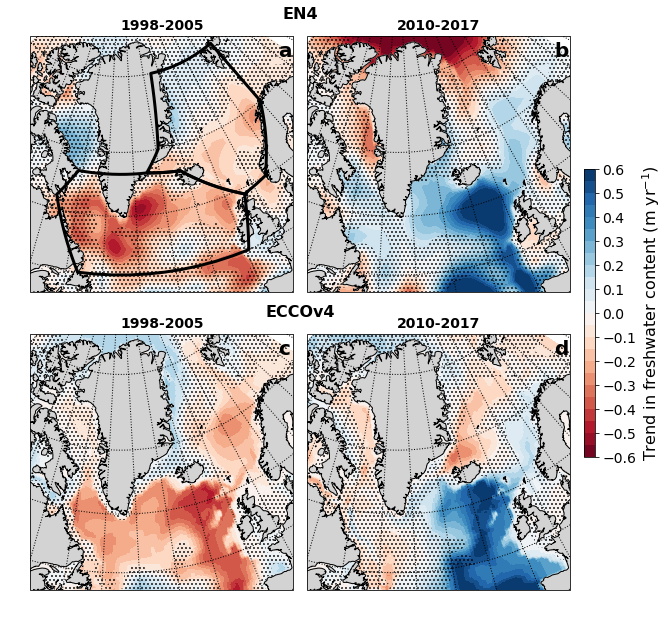

## Monthly seasonal anomalies

In [12]:
h_fw_ec_anom = h_fw_ec.groupby('time.month') - h_fw_ec.groupby('time.month').mean('time')
h_fw_en_anom = h_fw_en.groupby('time.month') - h_fw_en.groupby('time.month').mean('time')

In [13]:
# Annual mean freshwater content (km^3)
Vfw_spna_ec = (h_fw_ec_anom.salem.roi(shape=gdf_spna.loc[[0]]) * ec.area).sum(dim=['lat','lon'])*1e-9
Vfw_spna_en = (h_fw_en_anom.salem.roi(shape=gdf_spna.loc[[0]]) * en.area).sum(dim=['lat','lon'])*1e-9

/usr/local/lib/python3.6/dist-packages/salem/gis.py:66: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  out = pyproj.Proj(crs.to_proj4(), preserve_units=True)
/usr/local/lib/python3.6/dist-packages/salem/gis.py:66: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  out = pyproj.Proj(crs.to_proj4(), preserve_units=True)


In [14]:
def print_OLS_info(arr):
    model = sm.OLS(arr.values, sm.add_constant(arr.time.astype(int)/1e9/3600/24/365.25))
    results = model.fit()
    
    if results.params[1]>0:
        err = np.abs(results.conf_int()[1][0]-results.params[1])
    elif results.params[1]<0:
        err = np.abs(results.params[1]-results.conf_int()[1][1])
    
    print('Slope:',results.params[1])
    print('Intercept:',results.params[0])
    print('95% conf. int.:', results.conf_int()[1])
    print('Standard error:', results.bse[1])
    print('Err (+/-):', err)
    print('Slope/Err:', results.params[1]/err)
    print('p value:', results.pvalues[1])

In [15]:
print('\n','---- SPNA FW trend / ECCOv4r4 (1998-2005) ----')
print_OLS_info(Vfw_spna_ec.sel(time=slice('1998-01-01','2005-12-31')))

print('\n','---- SPNA FW trend / EN4 (1998-2005) ----')
print_OLS_info(Vfw_spna_en.sel(time=slice('1998-01-01','2005-12-31')))

print('\n','---- SPNA FW trend /ECCOv4r4 (2010-2017) ----')
print_OLS_info(Vfw_spna_ec.sel(time=slice('2010-01-01','2017-12-31')))

print('\n','---- SPNA FW trend / EN4 (2010-2017) ----')
print_OLS_info(Vfw_spna_en.sel(time=slice('2010-01-01','2017-12-31')))


 ---- SPNA FW trend / ECCOv4r4 (1998-2005) ----
Slope: -1108.0704840413694
Intercept: 35273.498553693935
95% conf. int.: [-1162.44169924 -1053.69926885]
Standard error: 27.383819325248144
Err (+/-): 54.371215195360264
Slope/Err: -20.379726295613967
p value: 2.875888290385794e-61

 ---- SPNA FW trend / EN4 (1998-2005) ----
Slope: -1192.4336082344485
Intercept: 37765.07418828731
95% conf. int.: [-1401.26577006  -983.60144641]
Standard error: 105.17738417520641
Err (+/-): 208.8321618234827
Slope/Err: -5.710009405746439
p value: 2.750336846441821e-19

 ---- SPNA FW trend /ECCOv4r4 (2010-2017) ----
Slope: 770.7690464955042
Intercept: -36708.297776668944
95% conf. int.: [708.48242039 833.05567261]
Standard error: 31.37038062607698
Err (+/-): 62.286626110192515
Slope/Err: 12.374551242058308
p value: 1.0715691790349131e-42

 ---- SPNA FW trend / EN4 (2010-2017) ----
Slope: 1137.8013096474256
Intercept: -50761.58198559024
95% conf. int.: [1013.69003518 1261.91258411]
Standard error: 62.5080882

In [16]:
def get_OLS_fit(arr):
    model = sm.OLS(arr.values, sm.add_constant(arr.time.astype(int)/1e9/3600/24/365.25))
    results = model.fit()
    
    if results.params[1]>0:
        err = np.abs(results.conf_int()[1][0]-results.params[1])
    elif results.params[1]<0:
        err = np.abs(results.params[1]-results.conf_int()[1][1])
    return results.params[1],results.params[0],err

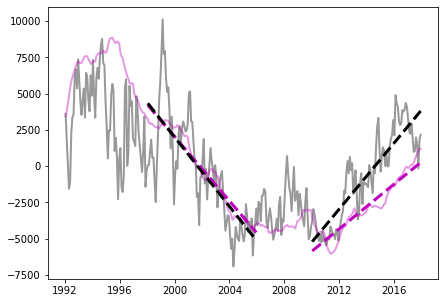

In [37]:
plt.figure(figsize=(7,5))

plt.plot(Vfw_spna_en.time,Vfw_spna_en,color='k', lw=2, ls='-', alpha=0.4)
plt.plot(Vfw_spna_ec.time,Vfw_spna_ec,color='m', lw=2, ls='-', alpha=0.4)

plt.plot(Vfw_spna_ec.sel(time=slice('1998-01-01','2005-12-31')).time, 
         get_OLS_fit(Vfw_spna_ec.sel(time=slice('1998-01-01','2005-12-31')))[0]*\
         Vfw_spna_ec.sel(time=slice('1998-01-01','2005-12-31')).time.astype(int)/1e9/3600/24/365.25+\
         get_OLS_fit(Vfw_spna_ec.sel(time=slice('1998-01-01','2005-12-31')))[1], c='m', lw=3,linestyle='--')

plt.plot(Vfw_spna_ec.sel(time=slice('2010-01-01','2017-12-31')).time, 
         get_OLS_fit(Vfw_spna_ec.sel(time=slice('2010-01-01','2017-12-31')))[0]*\
         Vfw_spna_ec.sel(time=slice('2010-01-01','2017-12-31')).time.astype(int)/1e9/3600/24/365.25+\
         get_OLS_fit(Vfw_spna_ec.sel(time=slice('2010-01-01','2017-12-31')))[1], c='m', lw=3,linestyle='--')

plt.plot(Vfw_spna_en.sel(time=slice('1998-01-01','2005-12-31')).time, 
         get_OLS_fit(Vfw_spna_en.sel(time=slice('1998-01-01','2005-12-31')))[0]*\
         Vfw_spna_en.sel(time=slice('1998-01-01','2005-12-31')).time.astype(int)/1e9/3600/24/365.25+\
         get_OLS_fit(Vfw_spna_en.sel(time=slice('1998-01-01','2005-12-31')))[1], c='k', lw=3,linestyle='--')

plt.plot(Vfw_spna_en.sel(time=slice('2010-01-01','2017-12-31')).time, 
         get_OLS_fit(Vfw_spna_en.sel(time=slice('2010-01-01','2017-12-31')))[0]*\
         Vfw_spna_en.sel(time=slice('2010-01-01','2017-12-31')).time.astype(int)/1e9/3600/24/365.25+\
         get_OLS_fit(Vfw_spna_en.sel(time=slice('2010-01-01','2017-12-31')))[1], c='k', lw=3,linestyle='--')

plt.show()

### Spatial trends for 1998-2005 and 2010-2017

In [17]:
t1i = '1998-01-01'
t1f = '2005-12-31'

t2i = '2010-01-01'
t2f = '2017-12-31'

In [18]:
FW_ec9805 = h_fw_ec_anom.sel(time=slice(t1i,t1f))
FW_ec1017 = h_fw_ec_anom.sel(time=slice(t2i,t2f))
FW_en9805 = h_fw_en_anom.sel(time=slice(t1i,t1f))
FW_en1017 = h_fw_en_anom.sel(time=slice(t2i,t2f))

In [20]:
# ECCOv4 1998-2005
t = FW_ec9805.time.astype(int)/1e9/3600/24/365.25
FW_ec9805_trend = xr.DataArray(np.apply_along_axis(get_trend, 2, FW_ec9805.transpose('lat','lon','time')),
                               coords=[FW_ec9805.lat,FW_ec9805.lon],dims=['lat','lon'])
FW_ec9805_ratio = xr.DataArray(np.apply_along_axis(get_ratio, 2, FW_ec9805.transpose('lat','lon','time')),
                               coords=[FW_ec9805.lat,FW_ec9805.lon],dims=['lat','lon'])

# ECCOv4 2010-2017
t = FW_ec1017.time.astype(int)/1e9/3600/24/365.25
FW_ec1017_trend = xr.DataArray(np.apply_along_axis(get_trend, 2, FW_ec1017.transpose('lat','lon','time')),
                               coords=[FW_ec1017.lat,FW_ec1017.lon],dims=['lat','lon'])
FW_ec1017_ratio = xr.DataArray(np.apply_along_axis(get_ratio, 2, FW_ec1017.transpose('lat','lon','time')),
                               coords=[FW_ec1017.lat,FW_ec1017.lon],dims=['lat','lon'])

# EN4 1998-2005
t = FW_en9805.time.astype(int)/1e9/3600/24/365.25
FW_en9805_trend = xr.DataArray(np.apply_along_axis(get_trend, 2, FW_en9805.transpose('lat','lon','time')),
                               coords=[FW_en9805.lat,FW_en9805.lon],dims=['lat','lon'])
FW_en9805_ratio = xr.DataArray(np.apply_along_axis(get_ratio, 2, FW_en9805.transpose('lat','lon','time')),
                               coords=[FW_en9805.lat,FW_en9805.lon],dims=['lat','lon'])

# EN4 2010-2017
t = FW_en1017.time.astype(int)/1e9/3600/24/365.25
FW_en1017_trend = xr.DataArray(np.apply_along_axis(get_trend, 2, FW_en1017.transpose('lat','lon','time')),
                               coords=[FW_en1017.lat,FW_en1017.lon],dims=['lat','lon'])
FW_en1017_ratio = xr.DataArray(np.apply_along_axis(get_ratio, 2, FW_en1017.transpose('lat','lon','time')),
                               coords=[FW_en1017.lat,FW_en1017.lon],dims=['lat','lon'])

### Change in freshwater content

In [23]:
DeltaFW_en1017 = h_fw_en_annual.sel(year=2017) - h_fw_en_annual.sel(year=2010)
DeltaFW_ec1017 = h_fw_ec_annual.sel(year=2017) - h_fw_ec_annual.sel(year=2010)

In [27]:
DeltaFW_en = h_fw_en_annual.sel(year=2015) - h_fw_en_annual.sel(year=2015)

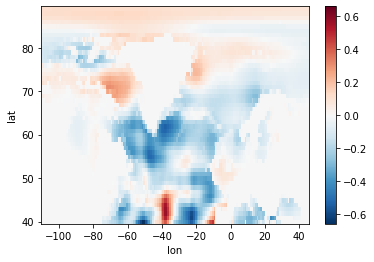

In [25]:
FW_en9805_trend.plot()

### Confidence ratio (check)

In [68]:
# define the colormap
cmap = plt.cm.bwr

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the center colors to be white
for x in range(round(cmap.N/2-cmap.N/10),round(cmap.N/2+cmap.N/10)):
    cmaplist[x] = (1,1,1,1.0)
    
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

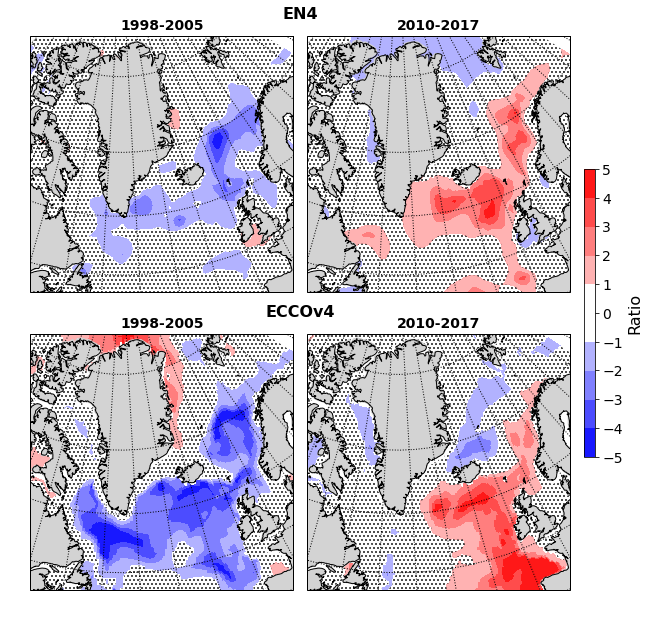

In [70]:
fig, row_axes = plt.subplots(figsize=(10,10), nrows=2, ncols=1, sharey=True)
fig.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, hspace=0.07, wspace = 0.05)

row_axes[0].set_title('EN4', fontsize=16, fontweight='bold')
row_axes[0].tick_params(axis='both',labelcolor=(1.,1.,1., 0.0), color=(1.,1.,1., 0.0),
                        top='off', bottom='off', left='off', right='off')
row_axes[0]._frameon = False

ax11 = fig.add_subplot(2,2,1,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax11.set_title(r'1998-2005', fontsize=14, fontweight='bold')
ax11.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax11.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax11.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax11.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))

p = ax11.contourf(h_fw_en_ratio9805.lon-0.5,h_fw_en_ratio9805.lat-0.5,
                  np.ma.masked_invalid(np.clip(h_fw_en_ratio9805,-5,5)), cmap=cmap, vmin=-5.0, vmax=5.0, 
                  levels=np.arange(-5,6,1),transform=cartopy.crs.PlateCarree())
ax11.contourf(h_fw_en_ratio9805.lon-0.5, h_fw_en_ratio9805.lat-0.5,
              np.ma.masked_invalid(np.clip(h_fw_en_ratio9805,-2,2)),
              levels=3, colors='none', hatches=['','...','...',''], transform=cartopy.crs.PlateCarree())

ax12 = fig.add_subplot(2,2,2,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax12.set_title(r'2010-2017', fontsize=14, fontweight='bold')
ax12.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax12.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax12.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax12.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))

p = ax12.contourf(h_fw_en_ratio1017.lon-0.5,h_fw_en_ratio1017.lat-0.5,
                  np.ma.masked_invalid(np.clip(h_fw_en_ratio1017,-5,5)), cmap=cmap, vmin=-5.0, vmax=5.0, 
                  levels=np.arange(-5,6,1),transform=cartopy.crs.PlateCarree())
ax12.contourf(h_fw_en_ratio1017.lon-0.5, h_fw_en_ratio1017.lat-0.5,
              np.ma.masked_invalid(np.clip(h_fw_en_ratio1017,-2,2)),
              levels=3, colors='none', hatches=['','...','...',''], transform=cartopy.crs.PlateCarree())


row_axes[1].set_title('ECCOv4', fontsize=16, fontweight='bold')
row_axes[1].tick_params(labelcolor=(1.,1.,1., 0.0), color=(1.,1.,1., 0.0),
                        top='off', bottom='off', left='off', right='off')
row_axes[1]._frameon = False

ax21 = fig.add_subplot(2,2,3,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax21.set_title(r'1998-2005', fontsize=14, fontweight='bold')
ax21.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax21.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax21.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax21.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))

p = ax21.contourf(h_fw_ec_ratio9805.lon-0.25,h_fw_ec_ratio9805.lat-0.25,
                  np.ma.masked_invalid(np.clip(h_fw_ec_ratio9805,-5,5)), cmap=cmap, vmin=-5.0, vmax=5.0, 
                  levels=np.arange(-5,6,1),transform=cartopy.crs.PlateCarree())
ax21.contourf(h_fw_ec_ratio9805.lon-0.25, h_fw_ec_ratio9805.lat-0.25,
              np.ma.masked_invalid(np.clip(h_fw_ec_ratio9805,-2,2)),
              levels=3, colors='none', hatches=['','...','...',''], transform=cartopy.crs.PlateCarree())

ax22 = fig.add_subplot(2,2,4,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax22.set_title(r'2010-2017', fontsize=14, fontweight='bold')
ax22.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax22.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax22.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax22.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))

p = ax22.contourf(h_fw_ec_ratio1017.lon-0.25,h_fw_ec_ratio1017.lat-0.25,
                  np.ma.masked_invalid(np.clip(h_fw_ec_ratio1017,-5,5)), cmap=cmap, vmin=-5.0, vmax=5.0, 
                  levels=np.arange(-5,6,1),transform=cartopy.crs.PlateCarree())

ax22.contourf(h_fw_ec_ratio1017.lon-0.25, h_fw_ec_ratio1017.lat-0.25,
              np.ma.masked_invalid(np.clip(h_fw_ec_ratio1017,-2,2)),
              levels=3, colors='none', hatches=['','...','...',''], transform=cartopy.crs.PlateCarree())

cax = fig.add_axes([0.87, 0.30, 0.015, 0.4])
cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.9, ticks=np.arange(-5,6,1))
cb.set_label(r'Ratio',fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.show()